In [22]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from lineartree import LinearTreeRegressor
from sklearn.svm import LinearSVR
from sklearn import neighbors
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import *
import joblib
from collections import defaultdict
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from pymongo import MongoClient
import warnings
from scipy import signal
import datetime
import csv
import os

import datetime
warnings.filterwarnings(action='ignore')


dfh : hvac data
dfs : sensor data

In [23]:
df_train = pd.read_feather('/home/deallab/harin/ECM/ecm_input.ftr')
df_train = df_train.set_index('timestamp_min')

In [24]:
df_train

,f3_hum,f10_hum,f3_temp,f10_temp,exthum,enhum,temp,entemp,extemp,F_SET_MODE_0,F_SET_MODE_1,F_SET_MODE_2,F_SET_MODE_3,F_SET_MODE_4,F_SET_MODE_5
timestamp_min,,,,,,,,,,,,,,,
2019-08-21 16:37:00,57.37,51.87,25.47,26.77,59.6,85.6,81.5,29.2,27.3,0,0,0,0,1,0
2019-08-21 16:38:00,57.37,51.87,25.47,26.77,59.4,85.4,107.6,29.2,27.1,0,0,0,0,1,0
2019-08-21 16:39:00,57.27,51.85,25.50,26.77,57.3,85.4,105.2,29.2,27.3,0,0,0,0,1,0
2019-08-21 16:40:00,57.27,51.87,25.60,26.77,58.3,85.6,82.5,29.2,27.5,0,0,0,0,1,0
2019-08-21 16:41:00,57.20,51.85,25.60,26.77,59.5,85.8,76.9,29.2,27.3,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-24 23:55:00,36.72,40.12,23.62,22.32,52.6,83.1,40.0,19.9,20.8,1,0,0,0,0,0
2019-10-24 23:56:00,36.72,40.10,23.62,22.42,52.8,82.8,40.0,19.9,20.8,1,0,0,0,0,0
2019-10-24 23:57:00,36.85,40.12,23.62,22.42,52.8,83.0,40.0,19.9,20.8,1,0,0,0,0,0


<AxesSubplot:xlabel='timestamp_min'>

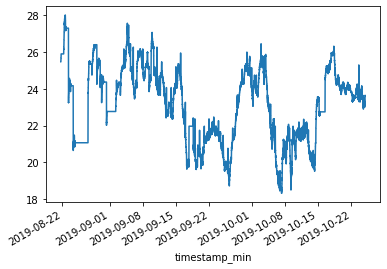

In [25]:
df_train.f3_temp.plot()

In [26]:
input_feature = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','enhum','temp','entemp','extemp','F_SET_MODE_0','F_SET_MODE_1','F_SET_MODE_2','F_SET_MODE_3','F_SET_MODE_4','F_SET_MODE_5']
output_feature = ['f3_hum','f10_hum','f3_temp','f10_temp','exthum','temp','extemp']

In [27]:
# 모델의 Timewindow별 학습하기 위한 데이터를 나눔


def train_model_data(df_s, Train_windows_size, Train_date ):
    
    df_train = df_s[((pd.to_datetime(df_s.index).date) >= (Train_date + datetime.timedelta(days=-Train_windows_size))) & 
           ((pd.to_datetime(df_s.index).date) < Train_date)]
    
    df_test = df_s[(pd.to_datetime(df_s.index).date) == (Train_date)]
    
    return df_train, df_test

In [28]:
# 모델 학습 및 결과 함수

def train_models(model_name, df_pre, Shift_Target, df_test_pre):
    
    if model_name == "xgb_regressor":
        model = MultiOutputRegressor(XGBRegressor(n_jobs=16))
    elif model_name == "xgbrf_regressor":
        model = MultiOutputRegressor(XGBRFRegressor(n_jobs=16))
    elif model_name == "linear_regression":
        model = MultiOutputRegressor(LinearRegression())
    elif model_name == "kneighbors_regressor":
        model = MultiOutputRegressor(neighbors.KNeighborsRegressor())
    elif model_name == "linear_svr":
        model = MultiOutputRegressor(LinearSVR(epsilon=0))
    elif model_name == "linear_tree_regressor":
        model = MultiOutputRegressor(
            LinearTreeRegressor(base_estimator=LinearRegression())
        )
    elif model_name == "extra_trees_regressor":
        model = MultiOutputRegressor(ExtraTreesRegressor(random_state= 26))
    
    #x_train, y_train =  multivariate_data(df_pre[input_feature].reset_index(drop=True).values, df_pre[output_feature].reset_index(drop=True).values, 0, None, past_history, future_target)
    #x_test, y_test =  multivariate_data(df_test_pre[input_feature].reset_index(drop=True).values, df_test_pre[output_feature].reset_index(drop=True).values, 0, None, past_history, future_target)
    #x_train = x_train.reshape(-1,past_history*len(input_feature))
    #x_test = x_test.reshape(-1,past_history*len(input_feature))
    x_train = df_pre[input_feature][:-10].values
    y_train = df_pre[output_feature][10:].values
    x_test = df_test_pre[input_feature][:-10].values
    y_test = df_test_pre[output_feature][10:].values
    model.fit(x_train, y_train) 
   
    #model.fit(df_pre[:-Shift_Target], df_pre[Shift_Target:])
    #model.fit(x_train, y_train) 
    y_pred = model.predict(x_test)
    
    
    mae = mean_absolute_error(y_pred[:,2], y_test[:,2])
    rmse = mean_squared_error(y_pred[:,2], y_test[:,2], squared=False)
    r2 = r2_score(y_pred[:,2], y_test[:,2])
    mape = mean_absolute_percentage_error(y_pred[:,2], y_test[:,2])
    
#     print(f"MAE : " , mae)
#     print("RMSE: ", rmse)
#     print("R2: ", r2)
#     print("MAPE: ", mape)
    
    h_mae = mean_absolute_error(y_pred[:,0], y_test[:,0])
    h_rmse = mean_squared_error(y_pred[:,0], y_test[:,0], squared=False)
    h_r2 = r2_score(y_pred[:,0], y_test[:,0])
    h_mape = mean_absolute_percentage_error(y_pred[:,0], y_test[:,0])
    
#     print(f"h_MAE : " , h_mae)
#     print("h_RMSE: ", h_rmse)
#     print("h_R2: ", h_r2)
#     print("h_MAPE: ", h_mape)
    
    return model, y_pred, [mae, rmse, r2, mape, h_mae, h_rmse, h_r2, h_mape] 

In [29]:
# 모델 결과 값 및 모델 저장
def model_save(Train_date, Train_windows_size, model_name, export_path, model, model_error ):
    
    model_filename = Train_date.strftime("%Y%m%d") + "w" + str(Train_windows_size) + "_" + model_name + ".joblib"
    
    filepath = os.path.join(export_path,model_filename)
    
    # extra_trees_regressor 모델 값이 너무 커서 저장하지 않음.
    # 향후 풀어야되는 문제임
    #if not model_name == "extra_trees_regressor":
    if not os.path.exists(f"{export_path}"):
        os.makedirs(f"{export_path}", exist_ok=True)
    if not os.path.isfile(filepath):
        with open(filepath, "wb") as f:
            joblib.dump(model, f)
    print(f"{model_filename} 에 ML 모델이 저장되었습니다.")



    #엑셀(csv) 저장
    f = open(csv_name,'a+', newline='')
    wr = csv.writer(f)
    wr.writerow([Train_date.strftime("%Y-%m-%d"), model_name, str(Train_windows_size), 
              model_error[0],model_error[1],model_error[2],model_error[3],
              model_error[4],model_error[5],model_error[6],model_error[7]])
    f.close()

In [ ]:
#모델 결과 값 저장
csv_name = "ecm_result.csv"

Shift_Target = 10

#모델 실행
model_list = [ #"linear_regression"
    "xgb_regressor", "xgbrf_regressor", 
             "kneighbors_regressor","linear_svr","linear_tree_regressor",
            "extra_trees_regressor"]


# 실험 파라메터
# Train Windows size
# Train 시작 일자



start_date = datetime.date(2019,8,23)
end_date = datetime.date(2019,10,25)
std  = datetime.date(2019,8,22)
# 날짜 array 생성
if (end_date-start_date).days == 0:
    end_date = start_date + datetime.timedelta(days=1)

Train_date_list = [start_date + datetime.timedelta(days=x) for x in range(0, (end_date-start_date).days)]

# 모델 학습

for Train_date in Train_date_list:
    if Train_date - std < datetime.timedelta(days=7) : Train_windows_size_list = [1]
    elif Train_date - std < datetime.timedelta(days=14) : Train_windows_size_list = [1,7]
    elif Train_date - std < datetime.timedelta(days=30) : Train_windows_size_list = [1,7,14]
    else : Train_windows_size_list = [1,7,14,30] #날짜
    export_path = os.path.join('/raid/deallab/ecm', "model_result")
    #export_path = os.path.join(os.getcwd(), "input wind")
    export_path = os.path.join(export_path, Train_date.strftime("%Y-%m-%d"))

    print(export_path)
    
    for Train_windows_size in Train_windows_size_list:

        df_pre, df_test_pre = train_model_data(df_train, Train_windows_size, Train_date )

        for m_name in model_list:

            model, y_pred, model_error  = train_models(m_name, df_pre, Shift_Target, df_test_pre)
            model_save(Train_date, Train_windows_size, m_name, export_path, model, model_error)

/raid/deallab/ecm/model_result/2019-08-23
20190823w1_xgb_regressor.joblib 에 ML 모델이 저장되었습니다.
20190823w1_xgbrf_regressor.joblib 에 ML 모델이 저장되었습니다.
20190823w1_kneighbors_regressor.joblib 에 ML 모델이 저장되었습니다.
20190823w1_linear_svr.joblib 에 ML 모델이 저장되었습니다.
20190823w1_linear_tree_regressor.joblib 에 ML 모델이 저장되었습니다.
20190823w1_extra_trees_regressor.joblib 에 ML 모델이 저장되었습니다.
/raid/deallab/ecm/model_result/2019-08-24
20190824w1_xgb_regressor.joblib 에 ML 모델이 저장되었습니다.
20190824w1_xgbrf_regressor.joblib 에 ML 모델이 저장되었습니다.
20190824w1_kneighbors_regressor.joblib 에 ML 모델이 저장되었습니다.
20190824w1_linear_svr.joblib 에 ML 모델이 저장되었습니다.
20190824w1_linear_tree_regressor.joblib 에 ML 모델이 저장되었습니다.
20190824w1_extra_trees_regressor.joblib 에 ML 모델이 저장되었습니다.
/raid/deallab/ecm/model_result/2019-08-25
20190825w1_xgb_regressor.joblib 에 ML 모델이 저장되었습니다.
20190825w1_xgbrf_regressor.joblib 에 ML 모델이 저장되었습니다.
20190825w1_kneighbors_regressor.joblib 에 ML 모델이 저장되었습니다.
20190825w1_linear_svr.joblib 에 ML 모델이 저장되었습니다.
20190825w1_linear_tree_r

20190906w1_linear_svr.joblib 에 ML 모델이 저장되었습니다.
20190906w1_linear_tree_regressor.joblib 에 ML 모델이 저장되었습니다.
20190906w1_extra_trees_regressor.joblib 에 ML 모델이 저장되었습니다.
20190906w7_xgb_regressor.joblib 에 ML 모델이 저장되었습니다.
20190906w7_xgbrf_regressor.joblib 에 ML 모델이 저장되었습니다.
20190906w7_kneighbors_regressor.joblib 에 ML 모델이 저장되었습니다.
20190906w7_linear_svr.joblib 에 ML 모델이 저장되었습니다.
20190906w7_linear_tree_regressor.joblib 에 ML 모델이 저장되었습니다.
20190906w7_extra_trees_regressor.joblib 에 ML 모델이 저장되었습니다.
20190906w14_xgb_regressor.joblib 에 ML 모델이 저장되었습니다.
20190906w14_xgbrf_regressor.joblib 에 ML 모델이 저장되었습니다.
20190906w14_kneighbors_regressor.joblib 에 ML 모델이 저장되었습니다.
20190906w14_linear_svr.joblib 에 ML 모델이 저장되었습니다.
20190906w14_linear_tree_regressor.joblib 에 ML 모델이 저장되었습니다.
20190906w14_extra_trees_regressor.joblib 에 ML 모델이 저장되었습니다.
/raid/deallab/ecm/model_result/2019-09-07
20190907w1_xgb_regressor.joblib 에 ML 모델이 저장되었습니다.
20190907w1_xgbrf_regressor.joblib 에 ML 모델이 저장되었습니다.
20190907w1_kneighbors_regressor.joblib 에 ML